# Data source

[Kaggle Repo](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

This dataset has 79 explanatory variables that describe many aspects of residential homes in Ames, Iowa. This project aims to predict the final prices of each home.


# Step 1: Data Ingestion

TODO: description here

In [83]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# only display up to 3 decimal points when pd is used in print()
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

in_file_paths = {
    'train': '../data/house-prices-advanced-regression-techniques/train.csv',
    'test': '../data/house-prices-advanced-regression-techniques/test.csv',
    'descriptions': '../data/house-prices-advanced-regression-techniques/data_description.txt',
}

# create output directory if it does not exist already
os.makedirs('./outputs', exist_ok=True)

train = pd.read_csv(in_file_paths['train'])
test = pd.read_csv(in_file_paths['test'])
print(f"successfully read dataset...\ntrain shape = {train.shape}\ntest shape = {test.shape}")

successfully read dataset...
train shape = (1460, 81)
test shape = (1459, 80)


In [84]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


## Cleaning

We will now deal with missing values and outliers.

In [88]:
nanDict = {
    'Total': train.isnull().sum(),
    'Pctg': train.isnull().sum() / train.isnull().count()
}

nanStats = pd.DataFrame.from_dict(nanDict).sort_values(by=['Total', 'Pctg'], ascending=False)
nanStats = nanStats[nanStats['Total'] > 0]
nanStats

,Total,Pctg
Fence,1179,0.808
MasVnrType,872,0.597
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageFinish,81,0.055
GarageQual,81,0.055
GarageCond,81,0.055
BsmtExposure,38,0.026


In [ ]:
# TODO: properly deal with NANs...

## Normalizing

Recall we are aiming to predict `SalePrice`, so we can start exploring this feature.

<Axes: xlabel='SalePrice', ylabel='Count'>

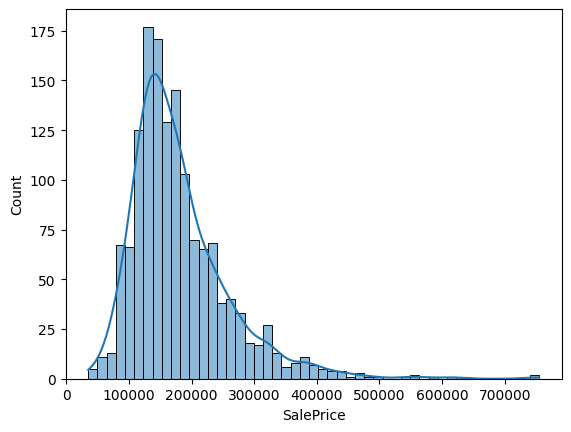

In [26]:
sns.histplot(train['SalePrice'], kde=True)

We can see that `SalePrice` is not normalized. Normalizing it will help the models we build (some models assume normal distributions among data).

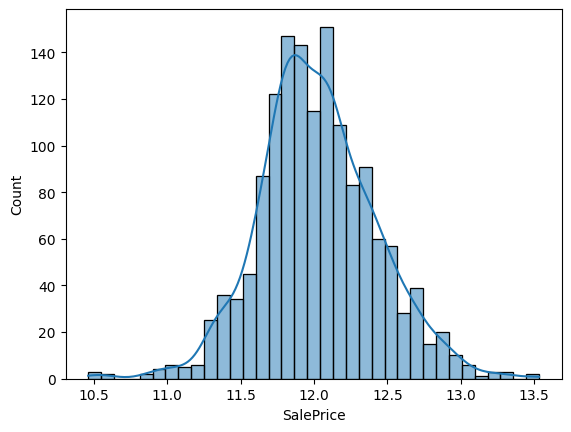

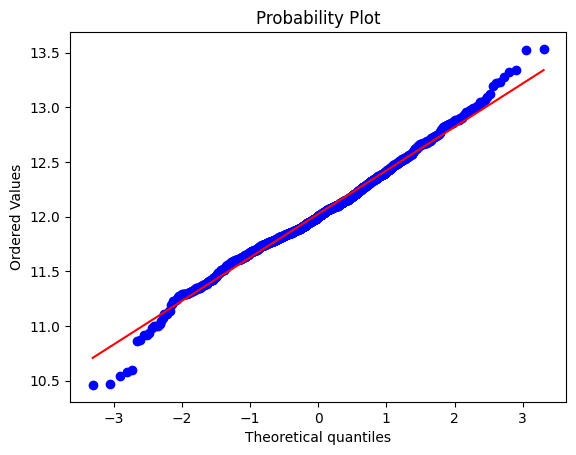

In [27]:
import numpy as np
from scipy import stats

normSalePrice = np.log1p(train['SalePrice'])

sns.histplot(normSalePrice, kde=True)
plt.figure()
stats.probplot(normSalePrice, plot=plt);

In [29]:
# above looks good so assign to DF
train['SalePrice'] = normSalePrice